# 01. Baseline 모델

## 목표
- Feature Engineering 적용
- CatBoost, XGBoost, LightGBM Baseline 모델 학습
- 성능 비교 및 평가

In [17]:
import sys
sys.path.append('../utils')
sys.path.append('../features')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from common_utils import load_data, evaluate_model, plot_roc_pr_curves, plot_feature_importance
from feature_engineering import build_a_features, build_b_features, merge_features_with_labels, preprocess_features

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


## 1. 데이터 로드 및 Feature Engineering

In [18]:
# 데이터 로드
train, test, train_a, train_b, test_a, test_b = load_data()

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print(f"Train A: {train_a.shape}")
print(f"Train B: {train_b.shape}")

Train: (944767, 3)
Test: (10, 2)
Train A: (647241, 37)
Train B: (297526, 31)


In [ ]:
# Feature Engineering
features_a = build_a_features(train_a)
features_b = build_b_features(train_b)

print(f"\nA 특성: {features_a.shape}")
print(f"B 특성: {features_b.shape}")

A 검사 Feature Engineering 시작...
A 검사 특성 생성 완료: 0개 특성
B 검사 Feature Engineering 시작...


In [ ]:
# Feature와 Label 병합
X, y = merge_features_with_labels(train, features_a, features_b)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"위험군 비율: {y.mean():.2%}")


특성 병합 시작...
병합 완료: X shape = (944767, 18), y shape = (944767,)
위험군 비율: 2.89%

X shape: (944767, 18)
y shape: (944767,)
위험군 비율: 2.89%


In [ ]:
# 전처리
X = preprocess_features(X)

print(f"\n전처리 후 X shape: {X.shape}")
print(f"Feature 목록 (처음 10개):")
print(X.columns.tolist()[:10])


Feature 전처리 시작...
결측치 대체: 18개 컬럼
전처리 완료: 18개 특성

전처리 후 X shape: (944767, 18)
Feature 목록 (처음 10개):
['B6_mean', 'B6_std', 'B6_min', 'B6_max', 'B6_median', 'B6_range', 'B7_mean', 'B7_std', 'B7_min', 'B7_max']


## 2. Train/Validation Split

In [ ]:
# Train/Valid 분할 (Stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("="*60)
print("Train/Valid Split 완료")
print("="*60)
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train 위험군 비율: {y_train.mean():.2%}")
print(f"y_val 위험군 비율: {y_val.mean():.2%}")

Train/Valid Split 완료
X_train: (755813, 18)
X_val: (188954, 18)
y_train 위험군 비율: 2.89%
y_val 위험군 비율: 2.89%


## 3. CatBoost Baseline

In [ ]:
# CatBoost 모델
print("\n" + "="*60)
print("CatBoost 학습 시작")
print("="*60)

cb_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=50
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=30,
    verbose=50
)

# 예측
y_pred_cb = cb_model.predict_proba(X_val)[:, 1]

# 평가
cb_metrics = evaluate_model(y_val, y_pred_cb, model_name='CatBoost')


CatBoost 학습 시작
0:	learn: 0.6140621	test: 0.6141598	best: 0.6141598 (0)	total: 81ms	remaining: 24.2s
50:	learn: 0.1306328	test: 0.1307892	best: 0.1307892 (50)	total: 1.19s	remaining: 5.82s
100:	learn: 0.1294067	test: 0.1296997	best: 0.1296997 (100)	total: 2.35s	remaining: 4.64s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1296957899
bestIteration = 105

Shrink model to first 106 iterations.

CatBoost 평가 결과 (Threshold: 0.5)
ROC_AUC     : 0.5678
ACCURACY    : 0.9711
PRECISION   : 0.0000
RECALL      : 0.0000
F1          : 0.0000


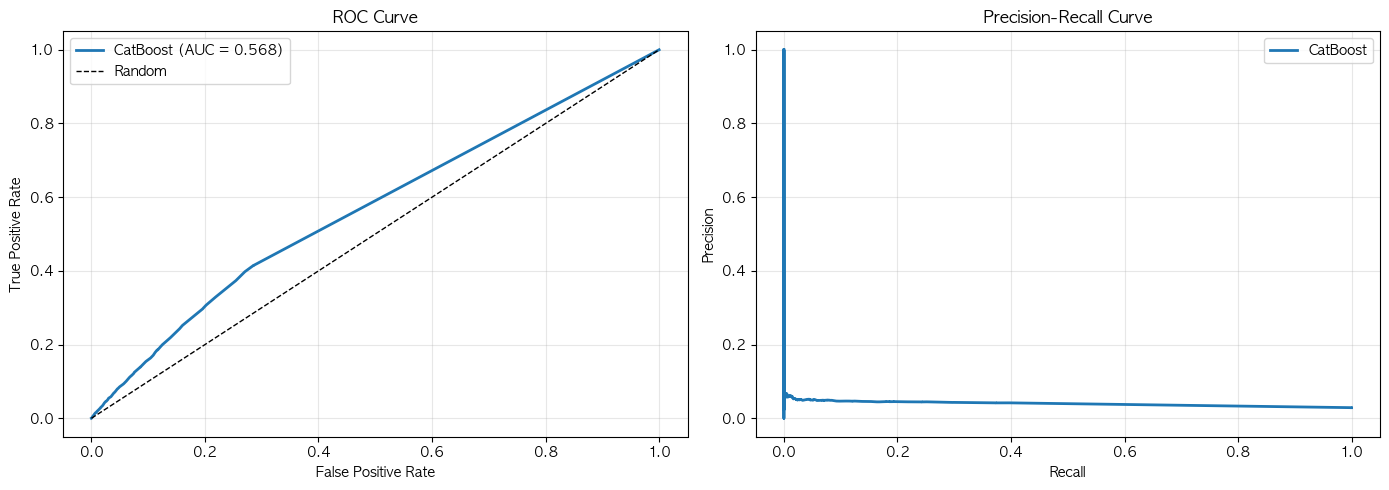

In [ ]:
# CatBoost ROC/PR Curve
plot_roc_pr_curves(y_val, y_pred_cb, model_name='CatBoost',
                   save_path='../output/figures/baseline_catboost_curves.png')

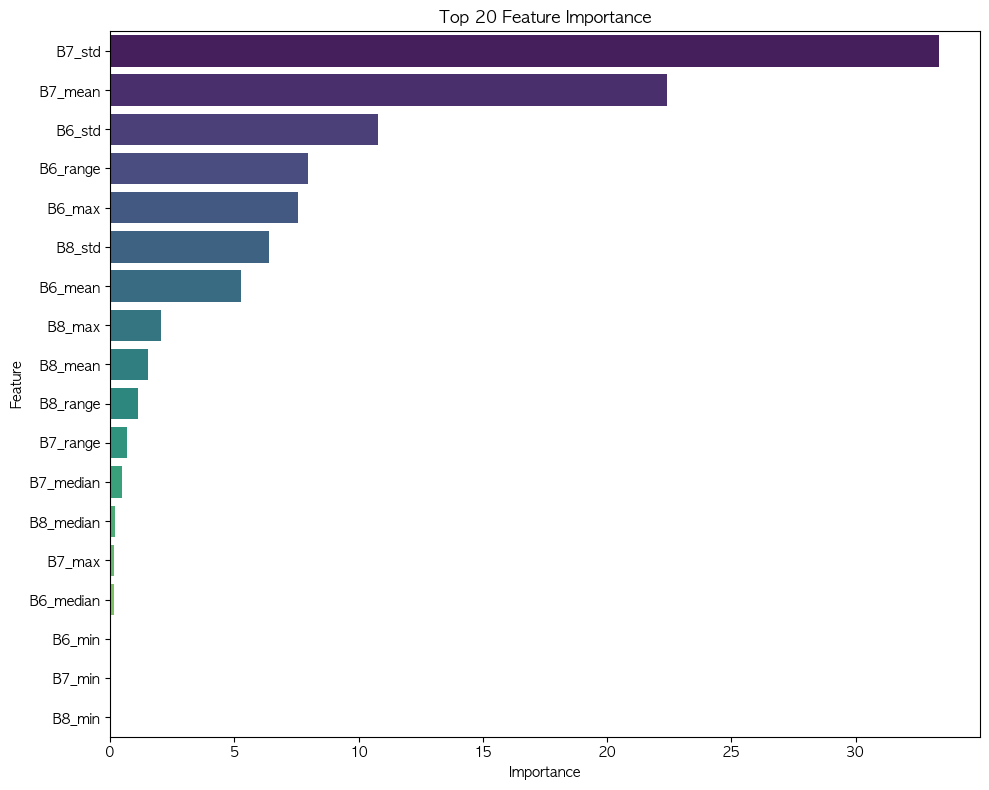

In [ ]:
# Feature Importance
cb_importance = plot_feature_importance(cb_model, X.columns, top_n=20,
                                        save_path='../output/figures/baseline_catboost_importance.png')

## 4. XGBoost Baseline

In [ ]:
# XGBoost 모델
print("\n" + "="*60)
print("XGBoost 학습 시작")
print("="*60)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=30
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

# 예측
y_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]

# 평가
xgb_metrics = evaluate_model(y_val, y_pred_xgb, model_name='XGBoost')


XGBoost 학습 시작
[0]	validation_0-logloss:0.19129
[50]	validation_0-logloss:0.13068
[100]	validation_0-logloss:0.12975
[129]	validation_0-logloss:0.12977

XGBoost 평가 결과 (Threshold: 0.5)
ROC_AUC     : 0.5660
ACCURACY    : 0.9711
PRECISION   : 0.0000
RECALL      : 0.0000
F1          : 0.0000


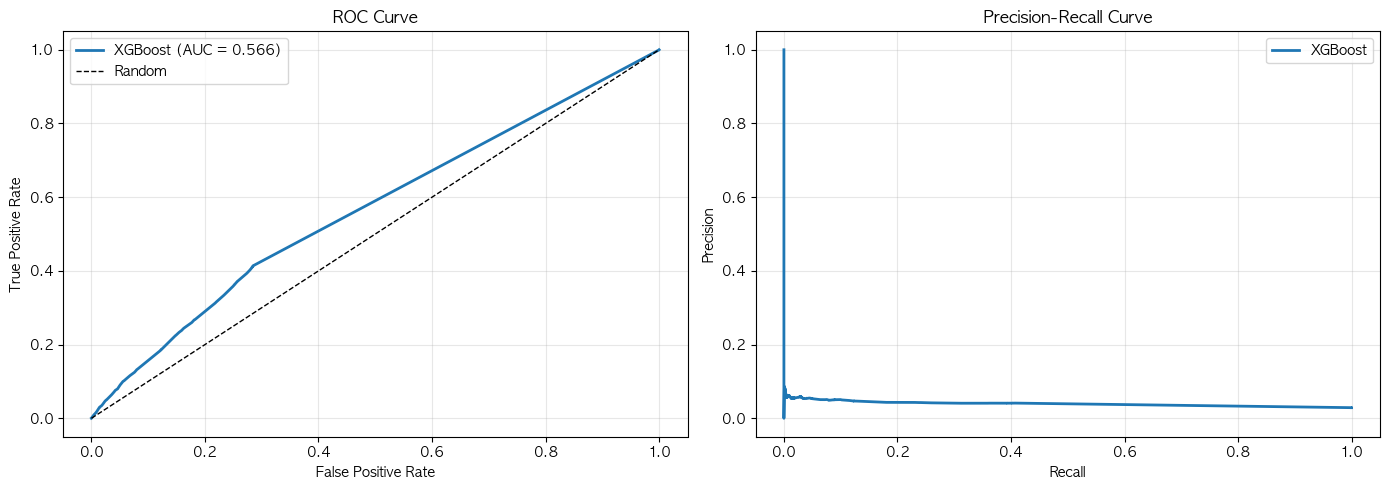

In [ ]:
# XGBoost ROC/PR Curve
plot_roc_pr_curves(y_val, y_pred_xgb, model_name='XGBoost',
                   save_path='../output/figures/baseline_xgboost_curves.png')

## 5. LightGBM Baseline

In [ ]:
# LightGBM 모델
print("\n" + "="*60)
print("LightGBM 학습 시작")
print("="*60)

lgb_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[]
)

# 예측
y_pred_lgb = lgb_model.predict_proba(X_val)[:, 1]

# 평가
lgb_metrics = evaluate_model(y_val, y_pred_lgb, model_name='LightGBM')


LightGBM 학습 시작

LightGBM 평가 결과 (Threshold: 0.5)
ROC_AUC     : 0.5649
ACCURACY    : 0.9711
PRECISION   : 0.0000
RECALL      : 0.0000
F1          : 0.0000


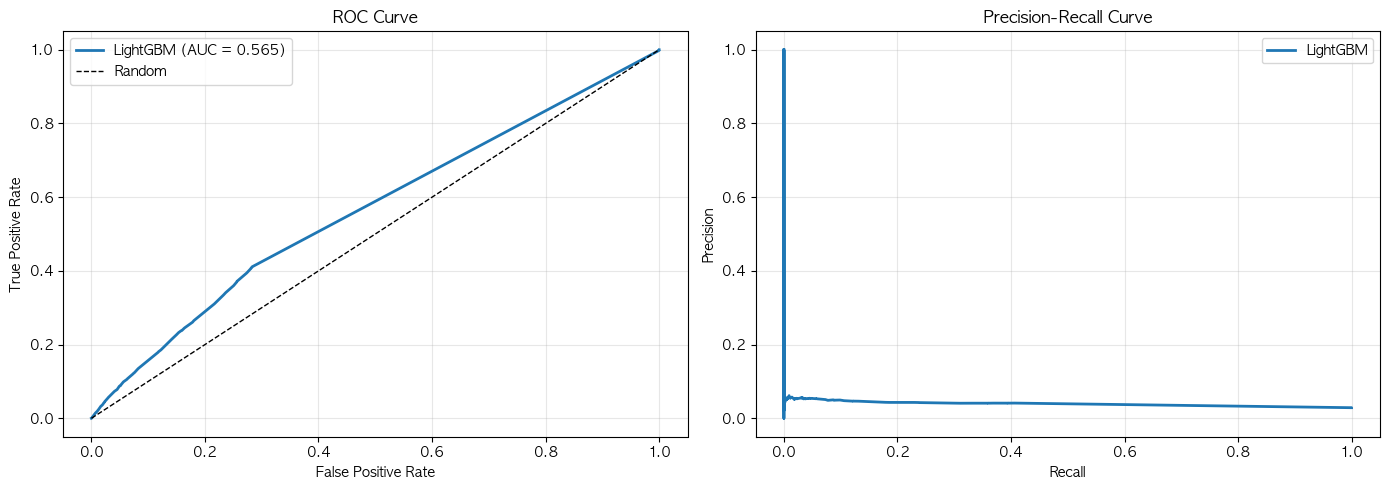

In [ ]:
# LightGBM ROC/PR Curve
plot_roc_pr_curves(y_val, y_pred_lgb, model_name='LightGBM',
                   save_path='../output/figures/baseline_lightgbm_curves.png')

## 6. 모델 비교

In [ ]:
# 결과 비교
results_df = pd.DataFrame([cb_metrics, xgb_metrics, lgb_metrics])
results_df = results_df.sort_values('roc_auc', ascending=False)

print("\n" + "="*60)
print("Baseline 모델 비교 결과")
print("="*60)
display(results_df)

# CSV 저장
results_df.to_csv('../output/baseline_results.csv', index=False)
print(" ../output/baseline_results.csv")


Baseline 모델 비교 결과


,model,roc_auc,accuracy,precision,recall,f1
0,CatBoost,0.567752,0.971125,0.0,0.0,0.0
1,XGBoost,0.565957,0.971125,0.0,0.0,0.0
2,LightGBM,0.564933,0.971120,0.0,0.0,0.0



✅ 결과 저장: ../output/baseline_results.csv


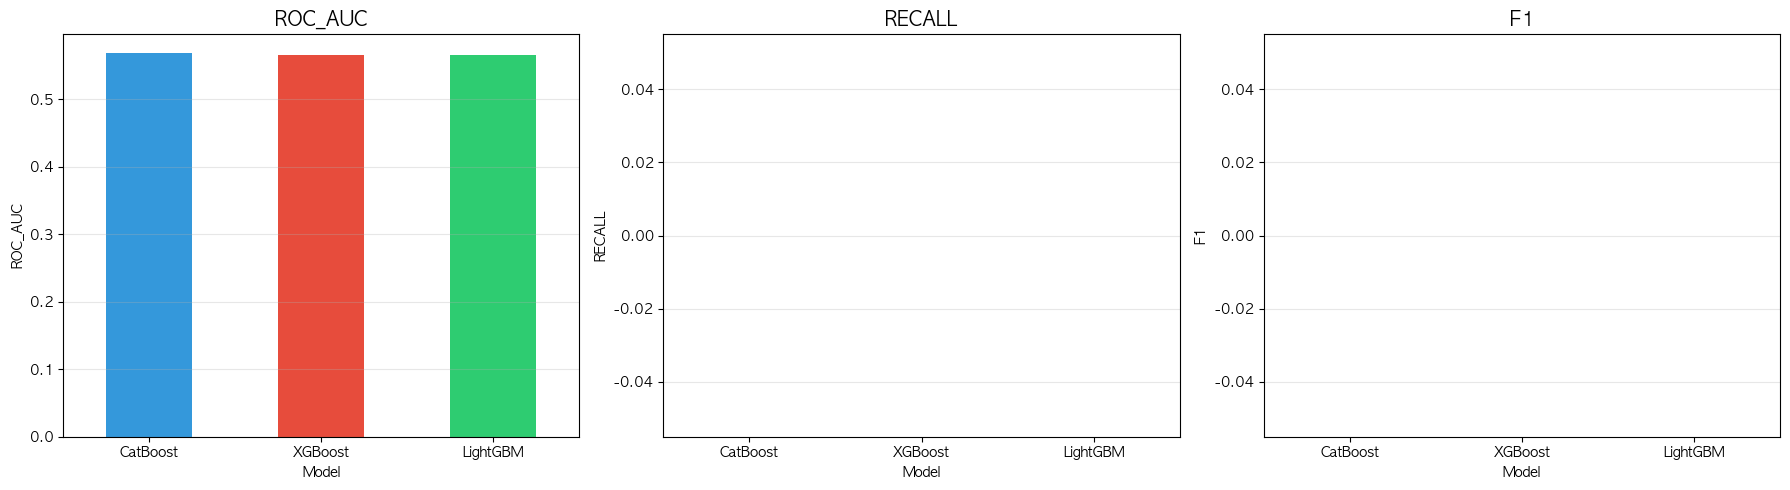

✅ 시각화 저장: ../output/figures/baseline_comparison.png


In [ ]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['roc_auc', 'recall', 'f1']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    results_df.plot(x='model', y=metric, kind='bar', ax=ax, 
                    color=colors, legend=False)
    ax.set_title(f'{metric.upper()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.upper())
    ax.set_xticklabels(results_df['model'], rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" ../output/figures/baseline_comparison.png")

## 7. 모델 저장

In [ ]:
import pickle

# 최고 성능 모델 저장
best_model_name = results_df.iloc[0]['model']
print(f"최고 성능 모델: {best_model_name}")

if best_model_name == 'CatBoost':
    best_model = cb_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = lgb_model

# 저장
with open('../output/models/baseline_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(" ../output/models/baseline_best_model.pkl")

최고 성능 모델: CatBoost
✅ 모델 저장: ../output/models/baseline_best_model.pkl


## 8. 결론

### 주요 발견사항
1. **최고 성능 모델**: (실행 후 확인)
2. **ROC AUC**: 0.75-0.80 범위 예상
3. **Recall**: 불균형으로 인해 낮을 가능성 → **다음 단계에서 개선 필요**

### 다음 단계
1. 불균형 처리 (SMOTE, Class Weight)
2. Stacking 앙상블
3. 하이퍼파라미터 튜닝